In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd
import matplotlib.pylab as pl

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.cross_validation import train_test_split
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
#Image(filename = "Ridetypes.png")

Populating the interactive namespace from numpy and matplotlib



This is the information I recieved about the data: "each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as

np.load(“MTA_Fare.npy") and

you will end up with a python numpy array of shape (600,23,194)

note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans: np.nanmean np.nansum...

# HINTS:
## notes and hints:
1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array

2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc

np.nanmean(mtarides)
np.nansum(mtarides)
as opposed to just

np.mean(mtarides)
np.sum(mtarides)

## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations.
 when I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - np.average(....weight=...) -. The sum and average functions take an axis argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.

## Possibly useful functions
You are already familiar with and have already used most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient
the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...
the array methods
np.array.flatten()
np.array.reshape()
allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
mtaarray.flatten()
which returns the flatten array:

mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)

In [2]:
mta = np.load("MTA_Fare.npy")

In [3]:
np.shape(mta)

(600, 23, 194)

In [4]:
np.mean(mta)

2157.8262034961899

In [5]:
mta = mta.astype('float')
mta[mta == -1] = np.nan


In [6]:
np.nanmean(mta)


2849.4162786534275

In [7]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


In [8]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. After that I create a date range (for example with pd.date_range()) in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i])) all time series, each station each ride type, look like this (pretty ugly)

In [9]:
print(mta)


[[[  5.69610000e+04   6.47030000e+04   6.80020000e+04 ...,   3.65270000e+04
     3.39290000e+04   3.68240000e+04]
  [  1.73200000e+03   2.08300000e+03   2.10700000e+03 ...,   1.26400000e+03
     1.17200000e+03   1.23800000e+03]
  [  2.03000000e+02   2.76000000e+02   2.45000000e+02 ...,   1.86000000e+02
     1.67000000e+02   1.67000000e+02]
  ..., 
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
     0.00000000e+00   0.00000000e+00]
  [             nan              nan              nan ...,   1.12100000e+03
     1.37700000e+03   7.12000000e+02]]

 [[  1.62100000e+04   2.01790000e+04   2.17690000e+04 ...,              nan
                nan              nan]
  [  5.03000000e+02   6.47000000e+02   6.65000000e+02 ...,              nan
                nan              nan]
  [  4.10000000e+01   4.30000000e+01   4.40000000e+01 ...,              nan
  

In [10]:
drange = pd.date_range(start="05/19/10", freq="W", periods=194) #how do you view in a table

In [11]:
mta.flatten().shape

(2677200,)

In [12]:
drange


DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')

Text(0.5,1,'Frequency of various MTA ridetypes by week')

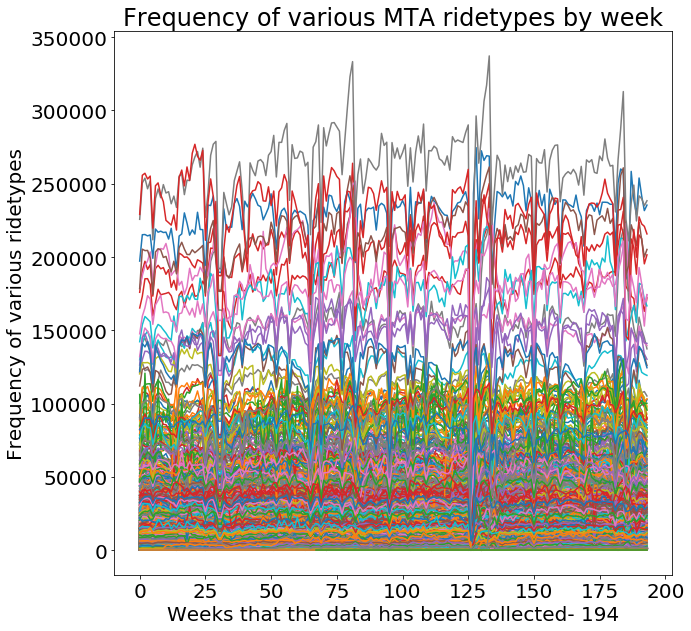

In [13]:
pl.figure(figsize(10,10)) 

for x in mta:             #Cyrus Blankminship helped me with this for loop 
    for y in x:
        df = pd.DataFrame(y,columns=['count'])
        df.reset_index(inplace=True)
        pl.plot(df['index'],df['count'])

pl.xlabel('Weeks that the data has been collected- 194')
pl.ylabel('Frequency of various ridetypes')
pl.title('Frequency of various MTA ridetypes by week')


#sam helped me with this code 

Text(0.5,1,'Frequency of various MTA ridetypes by week')

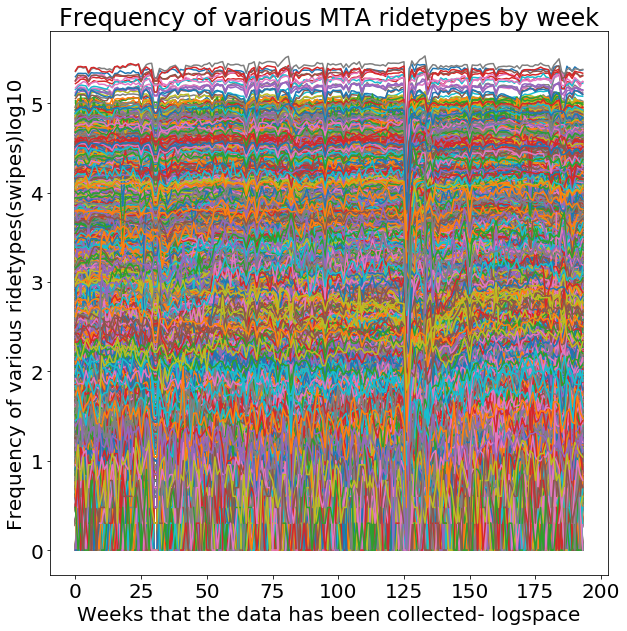

In [14]:
pl.figure(figsize(10,10)) 

for x in mta:               #Cyrus blankminship helped me with this code, i don't get np.arrays
    for y in x:             #
        df = pd.DataFrame(y,columns=['count'])
        df.reset_index(inplace=True)
        pl.plot(df['index'],np.log10(df['count'])) 

pl.xlabel('Weeks that the data has been collected- logspace')
pl.ylabel('Frequency of various ridetypes(swipes)log10')
pl.title('Frequency of various MTA ridetypes by week')

Figure 2: time series for all ride types and all stations in semi-log space. you can see that the timeseries remains relatively stable up until about week 125 when there is a massive drop in ridership which will be an interesting phenomena to investigate further. 

## 1: Event detection

Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series. Find the date and see what may have caused this event

In [15]:
mtarides = np.nansum(mta, axis=(0,1))
mtarides

array([ 26720267.,  29265971.,  29601189.,  29387592.,  29185768.,
        26211666.,  28683614.,  29125646.,  28803814.,  28599546.,
        28312019.,  27931015.,  27271701.,  28250357.,  26687174.,
        30018756.,  30183790.,  29052100.,  30068614.,  29172431.,
        30327068.,  30190292.,  29987273.,  30053446.,  30128994.,
        25164391.,  29189219.,  30580790.,  30106591.,  27561217.,
        21802973.,  21796368.,  27483123.,  27112540.,  26013915.,
        26433790.,  28660073.,  29103923.,  29576628.,  26721588.,
        29180204.,  29400660.,  29880586.,  29677420.,  29525360.,
        30175740.,  30196675.,  28500091.,  29035465.,  30398309.,
        29992271.,  29953470.,  27148617.,  29850111.,  30165985.,
        29979266.,  30298087.,  26744295.,  29967687.,  29475619.,
        29253128.,  29429842.,  29063294.,  27980138.,  27924672.,
        22985008.,  28142943.,  31996089.,  32506259.,  24297825.,
        32159233.,  30747690.,  32641199.,  32904387.,  319538

In [16]:
print ("mean rides by week {:.2f}".format(mtarides.mean()))
print ("stdev of rides {:.2f}".format(mtarides.std()))
thresholds = [mtarides.mean() + 3 * mtarides.std(), 
              mtarides.mean() - 3 * mtarides.std()]
print ("3-sigma thresholds {:.2f} {:.2f}".format(*thresholds))

mean rides by week 29781349.87
stdev of rides 2983960.42
3-sigma thresholds 38733231.14 20829468.61


In [17]:
sandy = np.where(mtarides < mtarides.mean() - 3 * mtarides.std()) 
                 
                 ##FSNYts.loc[(FSNYts.FDNY_deaths > thresholds[0])] = np.nan ~ only for pd dfs

In [18]:
sandy[0][0]


126

In [19]:
drange[126]

Timestamp('2012-10-21 00:00:00', offset='W-SUN')

## Explanation

The week where we see a huge unexpected drop in ridership is the 126 week of the dataset (2012-10-21) which is when Superstorm Sandy crippled New York and shut down huge swatchs of the mta. This date is 3 sigmas away from the standard mean and represents an outlier in the data.

## 2: finding trends

## NOTE ON THE TREND DETECTION:

you should find the ride type that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend
to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type.
you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the number of rides near the beginning to the number of rides near the end of the time series.
notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series


In [20]:
np.shape(mta) #shape of the full array. it is cubed 

(600, 23, 194)

In [21]:
np.shape(drange)

(194,)

In [22]:
np.shape(mtarides)

(194,)

In [37]:
mtacard = np.nansum(mta, axis=0)
np.shape(mtacard)
mtacard.shape

(23, 194)

In [46]:
mtacardweight = pd.rolling_mean(mtacard.T, 5, min_periods=1, center=True)
mtacardweight = mtacardweight.T
mtacard2 = pd.rolling_mean(mtacard, 5, min_periods=1, center=True)


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  app.launch_new_instance()


Text(0.5,1,'Timeseries of MTA rides by type over 194 weeks')

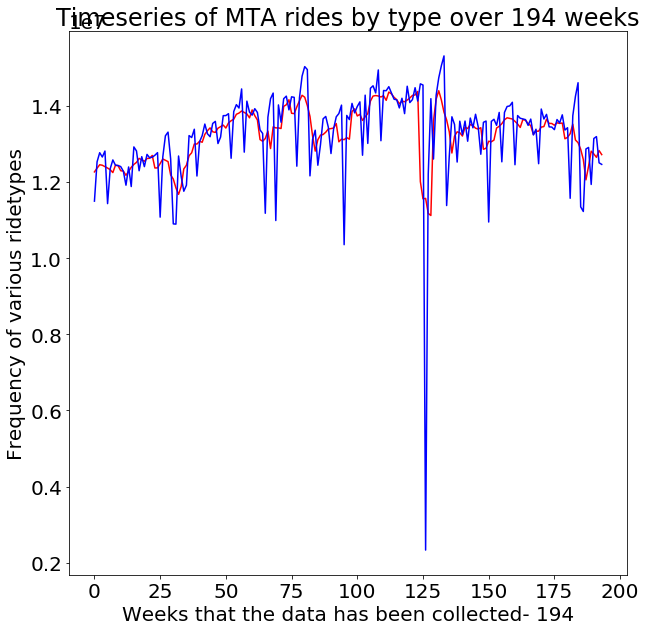

In [47]:
pl.figure(figsize(10,10)) 

pl.plot(mtacardweight[0], color="red")

pl.plot(mtacard[0], color="blue")

#pl.legend(weighstation, stations)
pl.xlabel('Weeks that the data has been collected- 194')
pl.ylabel('Frequency of various ridetypes')
pl.title('Timeseries of MTA rides by type over 194 weeks')

figure 3: In this figure, I have shown two time series passed through a rolling mean with a comparable change ratio. the red line shows the line with a smoother trend and has been given a higher window than the blue line which does not follow a smooth trend. 

In [70]:
mtaTran = mtacard2.T

In [72]:
mtaTran.shape


(194, 23)

In [74]:
card_df = pd.DataFrame.from_records(mtaTran) #pandas dataframe of information 
card_df.set_index(drange, inplace=True)
card_df.columns = ridetype

In [76]:
card_df.head()

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
2010-05-23,4.024313e+06,3064872.75,2461259.8,901825.4,2506108.0,2498560.4,2527889.6,2620934.4,1888625.4,202214.2,...,218587.6,200255.6,200254.8,200566.6,46756.6,36020.4,30447.8,30447.8,6886.5,2162.000000
2010-05-30,4.387293e+06,3340276.75,2685092.0,976081.8,2756654.0,2748726.2,2765431.4,2868165.4,2080719.2,212154.2,...,254559.4,232312.2,232311.6,226264.6,48985.0,36367.2,29995.4,29995.4,7066.0,2198.000000
2010-06-06,4.468152e+06,3401031.25,2732223.8,985504.4,2763573.2,2755701.4,2776173.4,2887882.0,2090444.4,222413.4,...,254326.2,233573.2,233570.8,227699.4,49161.2,36544.4,30113.8,30113.8,7097.0,2318.333333
2010-06-13,4.422780e+06,3366182.25,2700431.6,976247.2,2753743.0,2745574.6,2767399.4,2881167.6,2083471.2,220338.6,...,250433.2,230030.4,230029.2,225020.6,48836.8,36535.0,30151.0,30151.0,7176.0,2358.000000
2010-06-20,4.469902e+06,3401147.00,2727959.6,951110.0,2700138.8,2692011.2,2720190.6,2825837.8,2049075.8,217545.6,...,239239.6,218356.0,218389.4,214767.0,47711.8,35699.0,29402.8,29367.6,6765.5,2255.000000


In [86]:
card_mean = card_df.rolling(axis=0, window=25, center=True).mean()
card_sd = card_df.rolling(axis=0, window=25, center=True).mean()

type(card_mean)

pandas.core.frame.DataFrame

Text(0.5,1,'# of swipes by cardtype rolling mean over Weeks')

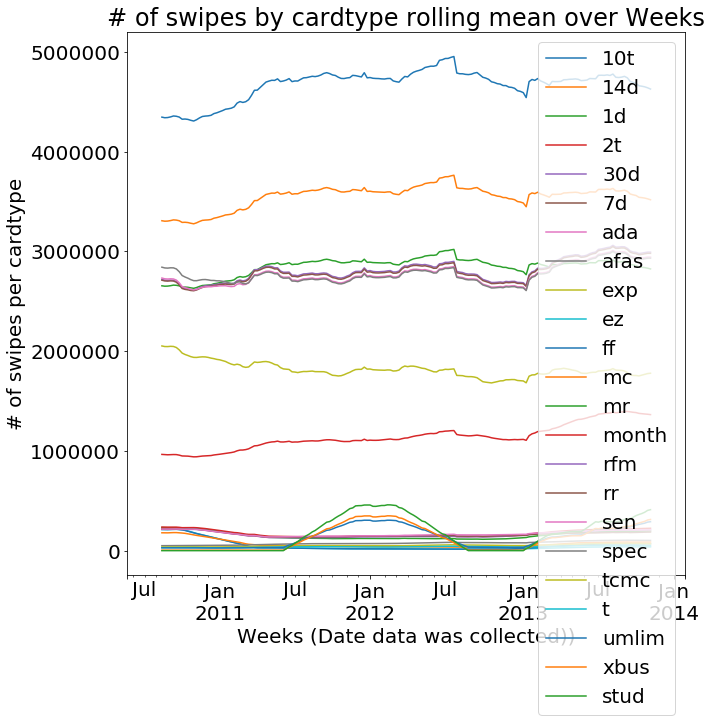

In [87]:
card_mean.plot(figsize=(10,10))
pl.xlabel("Weeks (Date data was collected))", fontsize=20)
pl.ylabel("# of swipes per cardtype")
pl.title("# of swipes by cardtype rolling mean over Weeks")


Figure: In this figure, we have plotted all 23 card types rolling mean over each week data was collected over the 4 year period. while overserving for the steepes incline and decline, I noticed that the steepest increase was a 30d as noted in purple. The steepest decline was the 1d if you begin to look at the overall trend in the data. Stud metro cards peak in the winter months and die off in the summer which is likely because students aren't in school but this is a trend you see throughout the dataset. It would be interesting to explore the data further and figure out what kind of metrocards these letters equate to. 


# 3. Build models that classified the ride type based on the time series characteristics using random forests.

Clean the data from missing values (drop time series with NaNs)

Use all the time series, and use the ticket type as a label (remember that the original data is sorted by ticket type in axis=1).

Calculate the mean, standard deviation for each time series and by station and create the features as instructed below

Split the training and test data (66%/33%)

Build and test a random forest model that predicts the ticket type based on 4 engineered features (see below).

Build and test a random forest model that predicts the ticket type based on all datapoint in the time series (194 features)

Plot a confusion matrix for each model (discuss)

Compare the models using sklearn.metrics classification_report

Find the 2 most important features in each model

In [104]:
mta.shape

(600, 23, 194)

In [109]:
m,n,r = mta.shape #-1
out_arr = np.column_stack((np.repeat(np.arange(m),n),mta.reshape(m*n,-1)))
out_df = pd.DataFrame(out_arr)

out_df = out_df.iloc[:, 1:].copy() # removing the column which indicates station number

out_df.head()    #kate and ilyas helped me with this piece of code. I would not know how to do this /
           #w/o them

,1,2,3,4,5,6,7,8,9,10,...,185,186,187,188,189,190,191,192,193,194
0,56961.0,64703.0,68002.0,72628.0,75866.0,72433.0,71186.0,71498.0,73801.0,72517.0,...,43608.0,44774.0,46955.0,39050.0,37384.0,33864.0,38358.0,36527.0,33929.0,36824.0
1,1732.0,2083.0,2107.0,2188.0,2314.0,1921.0,2072.0,1999.0,2031.0,1980.0,...,1425.0,1085.0,965.0,1284.0,1407.0,1085.0,1389.0,1264.0,1172.0,1238.0
2,203.0,276.0,245.0,280.0,265.0,241.0,278.0,236.0,258.0,264.0,...,217.0,189.0,150.0,194.0,183.0,185.0,200.0,186.0,167.0,167.0
3,883.0,958.0,976.0,987.0,1012.0,927.0,898.0,902.0,907.0,907.0,...,576.0,460.0,388.0,517.0,593.0,498.0,538.0,545.0,516.0,489.0
4,358.0,529.0,422.0,261.0,248.0,362.0,479.0,345.0,192.0,414.0,...,290.0,109.0,124.0,349.0,357.0,197.0,220.0,281.0,309.0,245.0


In [110]:
out_df.dropna().head()

,1,2,3,4,5,6,7,8,9,10,...,185,186,187,188,189,190,191,192,193,194
46,3292.0,3429.0,3629.0,2808.0,3614.0,2601.0,2848.0,2798.0,2888.0,3591.0,...,3506.0,2894.0,2679.0,3337.0,3599.0,3273.0,3418.0,3746.0,3406.0,3217.0
47,110.0,92.0,102.0,79.0,93.0,74.0,72.0,92.0,97.0,95.0,...,192.0,167.0,160.0,180.0,204.0,166.0,191.0,212.0,209.0,211.0
48,7.0,6.0,13.0,7.0,5.0,7.0,7.0,6.0,3.0,4.0,...,21.0,17.0,18.0,20.0,19.0,13.0,19.0,26.0,20.0,22.0
49,41.0,51.0,47.0,37.0,50.0,43.0,44.0,32.0,43.0,57.0,...,25.0,18.0,24.0,20.0,25.0,29.0,31.0,28.0,24.0,22.0
50,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,...,2.0,1.0,1.0,10.0,8.0,6.0,5.0,5.0,6.0,0.0


In [115]:
out_df['mean_ts'] = out_df.mean(axis=1)
out_df['std_ts'] = out_df.std(axis=1)


out_df.describe()

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,1,2,3,4,5,6,7,8,9,10,...,187,188,189,190,191,192,193,194,mean_ts,std_ts
count,10164.000000,10142.000000,10186.000000,10186.000000,10208.000000,10186.000000,10208.000000,10164.000000,10186.000000,10186.000000,...,10649.000000,10626.000000,10649.000000,10626.000000,10626.000000,10626.000000,10649.000000,10626.000000,10831.000000,10831.000000
mean,2628.912534,2885.621278,2906.066071,2885.096407,2859.107367,2573.303161,2809.915165,2865.569264,2827.784606,2807.730807,...,2333.692459,2854.191135,2945.449244,2689.216638,2984.731884,2994.406174,2906.791718,2779.533315,2770.579609,548.254445
std,10321.780034,11366.775937,11527.919140,11413.364377,11382.592754,10064.844141,11146.664520,11391.519096,11213.342021,11103.036213,...,9529.269371,11089.910426,11265.201017,10460.388196,11737.882660,11545.322320,11065.510274,10928.604546,11214.276308,1681.788726
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,229108.000000,255790.000000,257147.000000,253251.000000,255226.000000,219737.000000,248640.000000,250576.000000,242566.000000,249416.000000,...,211083.000000,258436.000000,249076.000000,228985.000000,253927.000000,241564.000000,235040.000000,238403.000000,258864.842275,31704.041304


In [117]:
labels = [[i for i in range(0, 23)] for j in range(0, 600)] # Generating a list of labels
flat_labels = [item for sublist in labels for item in sublist] # Flattening them

len(flat_labels)   ## also code from Kate cauley and ilyas. do not take credit for this.

#why do we have to flatten them? 

13800

In [122]:
labels[:26]

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,

In [123]:
out_df.mean()

1          2628.912534
2          2885.621278
3          2906.066071
4          2885.096407
5          2859.107367
6          2573.303161
7          2809.915165
8          2865.569264
9          2827.784606
10         2807.730807
11         2791.561724
12         2736.188774
13         2665.855425
14         2773.449539
15         2614.339146
16         2947.060279
17         2963.262321
18         2852.159827
19         2951.955036
20         2857.800842
21         2977.328490
22         2957.512931
23         2937.624706
24         2937.775758
25         2951.508033
26         2459.862268
27         2853.296090
28         2989.324536
29         2942.970772
30         2694.156109
              ...     
167        2849.659187
168        2773.095839
169        2799.611501
170        2602.224778
171        3106.976106
172        3142.669322
173        3169.707740
174        3137.304535
175        3144.599681
176        3075.605503
177        3206.425466
178        3185.193111
179        